## Cars - Exploration and Modelling using an alternative grouping of features

Here, we separate out the visibility changes to it's own feature and include the fullscreen feature into the contextual changes. Everything else remains the same.

In [266]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

sns.set_context('paper')
np.random.seed(42)

In [267]:
# read in the interaction metrics
statistics = pd.read_csv('data/cars_statistics.csv')

# read in the contextual data
contextual = pd.read_csv('data/cars_contextual_data.csv')

# get the distance from end metrics
target_metrics = pd.read_csv('data/abandonment_metrics.csv')
target_metrics = target_metrics[target_metrics.story == 'cars'].copy()

print(f"Number of users: {len(statistics.index)}")
print(f"Number of contextual samples: {len(contextual.index)}")
print(f"Number of samples in target metrics: {len(target_metrics.index)}")

Number of users: 41397
Number of contextual samples: 39882
Number of samples in target metrics: 40555


In [268]:
metrics = pd.merge(target_metrics, contextual, on = 'user', how = 'left')
metrics = metrics.merge(statistics, on = 'user', how = 'left')

print(f"Length of merged dataframe: {len(metrics.index)}")

Length of merged dataframe: 40555


As we're focusing on predicting the distance from the end, there are some features in the data that do not make sense to include - they'll increase depending on how far away someone is from the end. 

For example, the number of narrative elements seen will increase as a user progresses through the story, creating a feature that encodes the distance to the end. A similar effect will be seen with the session length and link choices clicked.

In [269]:
columns_to_drop = [
    # interaction-based features
    'LINK_CHOICE_CLICKED', 'NARRATIVE_ELEMENT_CHANGE', 'SUBTITLES_BUTTON_CLICKED',
    'USER_SET_VARIABLE', 'LINK_CHOICE_CLICKED_proportion', 'NARRATIVE_ELEMENT_CHANGE_proportion',
    'SUBTITLES_BUTTON_CLICKED_proportion', 'USER_SET_VARIABLE_proportion', 'total_events',
    'last_ne_seen',
    # time-based features
    'std_nec_time', 'med_nec_time', 'norm_std_nec_time', 'session_length', 'hidden_time', 
    'time_to_completion', 'raw_session_length', 'pre_std_nec_time', 'pre_norm_std_nec_time',
    # misc
    'reach_end'
]

metrics = metrics.drop(columns = columns_to_drop)

There is some additional contextual data that we can include that isn't already present - the orientation prior to entering the substory. This gives us an indication as to the orientation of the device, along with being able to infer whether the user is a mobile user or not. 

In [270]:
import pickle 

# load in the additional metadata
meta = pickle.load(open('data/cars_user_metadata.pickle', 'rb'))

# create a dataframe containing the particular feature that we're interested in
meta = pd.DataFrame(
    [(user, values['pre_substory_orientation']) for user, values in meta.items()],
    columns = ['user', 'pre_substory_orientation']
)

# merge it with the metrics dataframe, including a suffixes to help with removing any duplicates (there shouldn't be any, but it's worth doing)
metrics = metrics.merge(right = meta, how = 'left', on = 'user', suffixes = ('', '_drop'))
metrics = metrics.drop(metrics.filter(regex = '_drop$').columns.tolist(), axis = 1)

**Get Data Statistics**

In [271]:
# get all of the events for the substory
event_data = pickle.load(open('data/cars_data.pickle', 'rb'))

user_set = set(metrics.user.tolist())

event_lengths = [
    len(s_data['events'])
    for s_user, s_data in event_data.items()
    if s_user in user_set
]

assert len(user_set) == len(event_lengths)
print(f"Number of users: {len(user_set)}")
print(f"Events: M: {round(np.mean(event_lengths), 3)}, STD: {round(np.std(event_lengths), 3)}")
print(f"Total Number of events: {np.sum(event_lengths)}")

Number of users: 40555
Events: M: 79.559, STD: 371.022
Total Number of events: 3226503


**Separate out the UES Users**

In [272]:
ues_users = pd.read_csv('data/click_user_engagement_metrics.csv')
ues_users['present'] = np.where(ues_users.user_id.isin(metrics.user), True, False)
ues_users['present'].value_counts()

True     402
False     98
Name: present, dtype: int64

In [273]:
# drop the users where present is false 
ues_users = ues_users.drop(ues_users[ues_users.present == False].index)

# merge the metrics into the ues_users dataframe
ues_users = ues_users.merge(
    right = metrics, how = 'left', left_on = 'user_id', right_on = 'user'
)

# add a column to the metrics dataframe so we can drop those rows 
metrics['ues_user'] = np.where(metrics.user.isin(ues_users.user_id), True, False)

# drop the users that are ues_users from the metrics dataframe
metrics = metrics.drop(metrics[metrics.ues_user == True].index)

There should be no negative values present in the data - these can occur with data outliers

In [274]:
# remove them
metrics = metrics[metrics.select_dtypes(include = [np.number]).ge(0).all(1)]
metrics.describe()

,distance,pre_avg_nec_time,pre_norm_avg_nec_time,pre_link_choice_clicked,pre_narrative_element_change,pre_link_choice_ratio,avg_nec_time,norm_avg_nec_time,SP,MP,...,VOLUME_CHANGED_proportion,BACK_BUTTON_CLICKED_proportion,WINDOW_ORIENTATION_CHANGE_proportion,FULLSCREEN_BUTTON_CLICKED_proportion,VIDEO_SCRUBBED_proportion,PLAY_PAUSE_BUTTON_CLICKED_proportion,SEEK_BACKWARD_BUTTON_CLICKED_proportion,NEXT_BUTTON_CLICKED_proportion,SEEK_FORWARD_BUTTON_CLICKED_proportion,BROWSER_VISIBILITY_CHANGE_proportion
count,36912.000000,36912.000000,36912.000000,36912.000000,36912.000000,36912.000000,36912.000000,36912.000000,36912.000000,36912.000000,...,36912.000000,36912.000000,36912.000000,36912.000000,36912.000000,36912.000000,36912.000000,36912.000000,36912.000000,36912.000000
mean,2.136947,69.137461,0.811357,7.102460,6.047979,1.176214,143.563565,3.044111,1.582385,0.850238,...,0.000005,0.000076,0.000531,0.000082,0.000118,0.000112,0.000029,0.000217,0.000079,0.001063
std,1.887123,379.671696,2.884418,6.152247,0.540772,1.017638,2504.237793,77.209018,2.870251,1.519117,...,0.000096,0.000443,0.001002,0.000335,0.000546,0.000448,0.000213,0.000840,0.000492,0.001592
min,0.000000,2.741000,0.023000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,52.427000,0.690000,4.000000,6.000000,0.667000,26.505479,0.451542,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,55.565500,0.757000,5.000000,6.000000,0.833000,48.855800,0.789889,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,60.532000,0.784000,8.000000,6.000000,1.333000,78.389316,0.997302,2.000000,1.000000,...,0.000000,0.000000,0.000769,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001667
max,6.000000,41202.275000,320.521000,165.000000,28.000000,27.500000,243722.566000,7811.620705,135.000000,24.000000,...,0.005000,0.006667,0.009730,0.005000,0.008689,0.007944,0.007692,0.008108,0.008000,0.009907


**Grouping Features**

To simplify the modelling and exploration process, we'll group related features together - i.e., back button clicks and seek backward clicks as backward navigation. We know from prior work that a lot of these events record low counts, so there could be additional information when grouping. **This is where we've updated from the other notebook, it's where browser visibility changes are own their own and fullscreen is included in contextual**

In [275]:
from lib.helpers import COUNT_GROUPS, PROPORTION_GROUPS

# create the grouped features by summing the count values and the proportion values (multiplied by 100)
for group, columns in COUNT_GROUPS['alternative_groupings'].items():
    metrics[group] = metrics[columns].sum(axis = 1)
    
for group, columns in PROPORTION_GROUPS['alternative_groupings'].items():
    if group == 'browser_visibility_change_proportion':
        metrics = metrics.rename(columns = {columns[0]: group})
        metrics[group] = metrics[group].apply(lambda x: x * 100)
    else:
        metrics[group] = metrics[columns].sum(axis = 1) * 100
        
# we now want to drop the original columns 
import itertools 
droppable_columns = list(
    itertools.chain.from_iterable(list(COUNT_GROUPS['alternative_groupings'].values()))
)
droppable_columns += list(
    itertools.chain.from_iterable(list(PROPORTION_GROUPS['alternative_groupings'].values()))
)
droppable_columns.remove('BROWSER_VISIBILITY_CHANGE_proportion')

metrics = metrics.drop(columns = droppable_columns)
metrics.columns

Index(['user', 'distance', 'story', 'pre_avg_nec_time',
       'pre_norm_avg_nec_time', 'pre_link_choice_clicked',
       'pre_narrative_element_change', 'pre_link_choice_ratio', 'avg_nec_time',
       'norm_avg_nec_time', 'SP', 'MP', 'LP', 'VLP',
       'browser_visibility_change_proportion', 'pre_substory_orientation',
       'ues_user', 'back_nav', 'forward_nav', 'contextual', 'video_general',
       'browser_visibility_change', 'back_nav_proportion',
       'forward_nav_proportion', 'contextual_proportion',
       'video_general_proportion'],
      dtype='object')

In [276]:
metrics = metrics[metrics.avg_nec_time < metrics.avg_nec_time.quantile(0.97)]
metrics = metrics[metrics.norm_avg_nec_time < metrics.norm_avg_nec_time.quantile(0.96)]

print(f"Number of samples: {len(metrics.index)}")

metrics = metrics[metrics.pre_avg_nec_time < metrics.pre_avg_nec_time.quantile(0.99)]
metrics = metrics[metrics.pre_norm_avg_nec_time < metrics.pre_norm_avg_nec_time.quantile(0.99)]

print(f"Number of samples: {len(metrics.index)}")

Number of samples: 34371
Number of samples: 33685


**Encoding Categorical Variables**

In [277]:
metrics[['back_nav', 'forward_nav']].describe()

,back_nav,forward_nav
count,33685.000000,33685.000000
mean,0.322814,0.674098
std,2.115545,2.938683
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,89.000000,240.000000


In [278]:
num_users = len(metrics.index)
metrics[['back_nav', 'forward_nav']].apply(lambda x: (np.count_nonzero(x) / num_users) * 100)

back_nav        5.337687
forward_nav    12.346742
dtype: float64

In [279]:
metrics[['back_nav', 'forward_nav']] = metrics[['back_nav', 'forward_nav']].astype(bool)
metrics[['back_nav', 'forward_nav']].apply(pd.Series.value_counts, normalize = True) * 100

metrics['mobile'] = np.where(metrics.pre_substory_orientation.isin(['horizontal', 'vertical']), True, False)
metrics['pre_substory_orientation'] = np.where(
    (metrics.pre_substory_orientation == 'unknown'), 'horizontal', metrics.pre_substory_orientation
)

In [280]:
metrics.mobile.value_counts(normalize = True) * 100

True     55.261986
False    44.738014
Name: mobile, dtype: float64

In [281]:
metrics.pre_substory_orientation.value_counts(normalize = True) * 100

horizontal    98.937212
vertical       1.062788
Name: pre_substory_orientation, dtype: float64

In [282]:
metrics = pd.get_dummies(metrics, columns = ['pre_substory_orientation'], drop_first = True)

In [283]:
from lib.helpers import PRETTY_NAMES
metrics = metrics.rename(columns = PRETTY_NAMES)
metrics.columns

Index(['user', 'distance', 'story', 'Avg NEC Time (Pre)',
       'Norm Avg NEC Time (Pre)', '# Link Choices (Pre)', '# NEC (Pre)',
       'Link Choice Ratio (Pre)', 'Avg NEC Time', 'Norm Avg NEC Time',
       '# Short Pauses', '# Medium Pauses', '# Long Pauses',
       '# Very Long Pauses', 'Visibility Change (Proportion)', 'ues_user',
       'Navigation - Backwards (Bool)', 'Navigation - Forward (Bool)',
       '# Contextual Changes', '# General Video Controls',
       '# Visibility Change', 'Navigation - Backwards (Proportion)',
       'Navigation - Forwards (Proportion)', 'Contextual Changes (Proportion)',
       'General Video Controls (Proportion)', 'Mobile Device (Inferred)',
       'Vertical Orientation (Pre) Bool'],
      dtype='object')

### Features - Exploration

**Average NEC Time and Normalised Average NEC Time**

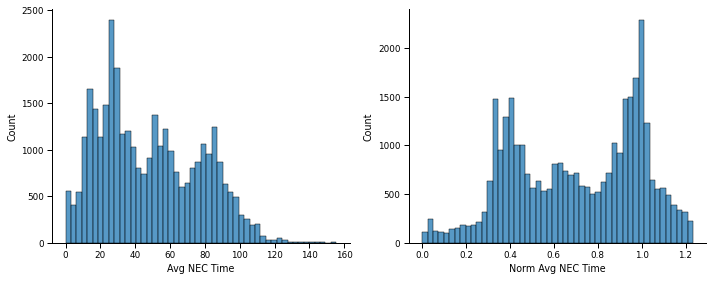

In [284]:
fig, ax = plt.subplots(ncols = 2, figsize = (10, 4))
sns.histplot(data = metrics['Avg NEC Time'], stat = 'count', bins = 50, ax = ax[0])
sns.histplot(data = metrics['Norm Avg NEC Time'], stat = 'count', bins = 50, ax = ax[1])
sns.despine()
plt.tight_layout()
plt.show()


Similar to the Malawi sub-story, there is a peak of users around the 100% mark for the normalised average time spent on narrative elements, but it's not as strong. Does this suggest there is more variability in the amount of time spent on narrative elements for Cars than Malawi? 

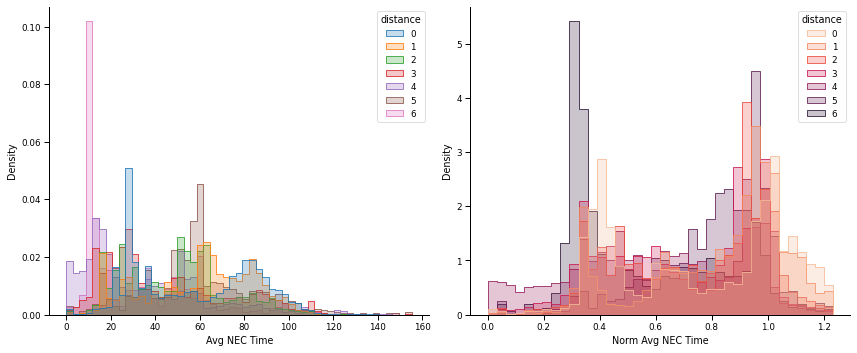

In [285]:
fig, ax = plt.subplots(ncols = 2, figsize = (12, 5))
p = sns.histplot(
    data = metrics, x = 'Avg NEC Time', hue = 'distance', element = 'step', stat = 'density', 
    common_norm = False, ax = ax[0], palette = sns.color_palette(n_colors = 7)
)
q = sns.histplot(
    data = metrics, x = 'Norm Avg NEC Time', hue = 'distance', element = 'step', stat = 'density',
    common_norm = False, ax = ax[1], palette = sns.color_palette('rocket_r', n_colors = 7)
)
sns.despine()
plt.tight_layout()
plt.show()

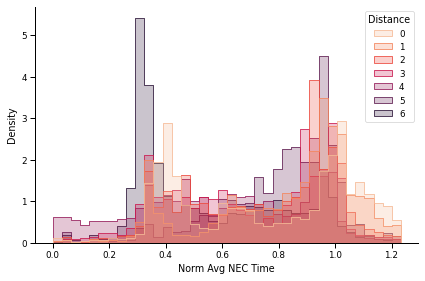

In [286]:
p = sns.histplot(
    data = metrics, x = 'Norm Avg NEC Time', hue = 'distance', 
    element = 'step', stat = 'density', common_norm = False, 
    palette = sns.color_palette('rocket_r', n_colors = 7)
)
p.legend_.set_title('Distance')
sns.despine()
plt.tight_layout()
plt.show()
# plt.savefig('plots/cars_normalised_average_nec_time_across_distances.png')

There is a high proportion of users that didn't not finish having a low normalised average NEC Time - this is likely due to them dropping out early in the sub-story. Users that finish or drop out closer to the end tend to spend more time on narrative elements (shown by their presence beyond 100%).

In [287]:
metrics.columns

Index(['user', 'distance', 'story', 'Avg NEC Time (Pre)',
       'Norm Avg NEC Time (Pre)', '# Link Choices (Pre)', '# NEC (Pre)',
       'Link Choice Ratio (Pre)', 'Avg NEC Time', 'Norm Avg NEC Time',
       '# Short Pauses', '# Medium Pauses', '# Long Pauses',
       '# Very Long Pauses', 'Visibility Change (Proportion)', 'ues_user',
       'Navigation - Backwards (Bool)', 'Navigation - Forward (Bool)',
       '# Contextual Changes', '# General Video Controls',
       '# Visibility Change', 'Navigation - Backwards (Proportion)',
       'Navigation - Forwards (Proportion)', 'Contextual Changes (Proportion)',
       'General Video Controls (Proportion)', 'Mobile Device (Inferred)',
       'Vertical Orientation (Pre) Bool'],
      dtype='object')

In [288]:
metrics[[
    '# Contextual Changes', '# General Video Controls', '# Visibility Change',
    '# Short Pauses', '# Medium Pauses', '# Long Pauses', '# Very Long Pauses'
]].describe()

,# Contextual Changes,# General Video Controls,# Visibility Change,# Short Pauses,# Medium Pauses,# Long Pauses,# Very Long Pauses
count,33685.000000,33685.000000,33685.000000,33685.000000,33685.000000,33685.000000,33685.000000
mean,0.748731,0.402256,0.934392,1.492326,0.798486,0.379813,3.403889
std,1.728819,1.893412,1.869074,2.622145,1.452899,0.791998,3.057800
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,3.000000
75%,1.000000,0.000000,1.000000,2.000000,1.000000,1.000000,5.000000
max,72.000000,206.000000,77.000000,52.000000,23.000000,16.000000,40.000000


**Pauses**

In [289]:
metrics.groupby('distance')[[
    '# Short Pauses', '# Medium Pauses', '# Long Pauses', '# Very Long Pauses'
]].aggregate(['mean', 'std', 'median'])

# Short Pauses                  # Medium Pauses                   \
                   mean       std median            mean       std median   
distance                                                                    
0              1.694246  3.073147      0        1.003310  1.778751      0   
1              1.926819  2.797157      1        0.952955  1.521302      0   
2              1.604233  2.645132      1        0.777955  1.369222      0   
3              1.404876  2.443204      1        0.656849  1.224568      0   
4              1.133537  1.952353      1        0.615075  1.074201      0   
5              1.599178  2.266158      1        0.812950  1.272516      0   
6              1.102016  1.967332      0        0.533293  1.048178      0   

         # Long Pauses                  # Very Long Pauses                   
                  mean       std median               mean       std median  
distance                                                                     
0             0.510014  0.960866      0           5.133232  3.281198      4  
1             0.474065  0.850932      0           4.377965  2.851424      3  
2             0.390575  0.760075      0           3.229633  2.470680      3  
3             0.261697  0.631009      0           2.593574  2.389602      2  
4             0.273459  0.606925      0           1.545391  2.050256      1  
5             0.397739  0.734983      0           3.209661  2.344600      3  
6             0.252291  0.590679      0           1.548564  1.477912      1

**Descriptive Statistics - Proportion of Events**

This is descriptive value of the percentage of users that register at least one of the interaction metrics.

In [290]:
interaction_metrics_based_on_interactions = [
    '# Link Choices (Pre)', '# NEC (Pre)', '# Short Pauses', 
    '# Medium Pauses', '# Long Pauses', '# Very Long Pauses', '# Contextual Changes', 
    '# General Video Controls', '# Visibility Change'
]
num_users = len(metrics.index)
metrics[interaction_metrics_based_on_interactions].apply(lambda x: (np.count_nonzero(x) / num_users) * 100)

# Link Choices (Pre)         97.242096
# NEC (Pre)                 100.000000
# Short Pauses               51.402701
# Medium Pauses              40.187027
# Long Pauses                26.335164
# Very Long Pauses           86.210479
# Contextual Changes         37.767552
# General Video Controls     14.472317
# Visibility Change          47.605759
dtype: float64

In [291]:
metrics['General Video Controls (Proportion)'].describe()

count    33685.000000
mean         0.019636
std          0.068646
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.830645
Name: General Video Controls (Proportion), dtype: float64

This tells us that 47.60% of users registered at least one visibility change event.

As the distance decreases, the average number of pauses increases.

**Correlation Analysis**

In [292]:
interaction_metrics = [
    'Avg NEC Time (Pre)', 'Norm Avg NEC Time (Pre)', '# Link Choices (Pre)', '# NEC (Pre)', 
    'Link Choice Ratio (Pre)', 'Avg NEC Time', 'Norm Avg NEC Time', '# Short Pauses', 
    '# Medium Pauses', '# Long Pauses', '# Very Long Pauses', 'Visibility Change (Proportion)',
    'Navigation - Backwards (Bool)', 'Navigation - Forward (Bool)', '# Contextual Changes', 
    '# General Video Controls', '# Visibility Change', 'Navigation - Backwards (Proportion)',
    'Navigation - Forwards (Proportion)', 'Contextual Changes (Proportion)',
    'General Video Controls (Proportion)', 'Mobile Device (Inferred)',
    'Vertical Orientation (Pre) Bool'
]

metrics[interaction_metrics + ['distance']].corr(method = 'spearman').filter(['distance']).drop(['distance'])

,distance
Avg NEC Time (Pre),-0.022574
Norm Avg NEC Time (Pre),-0.046558
# Link Choices (Pre),-0.005147
# NEC (Pre),-0.011284
Link Choice Ratio (Pre),-0.003560
Avg NEC Time,-0.327922
Norm Avg NEC Time,-0.217446
# Short Pauses,-0.023825
# Medium Pauses,-0.076279
# Long Pauses,-0.109258


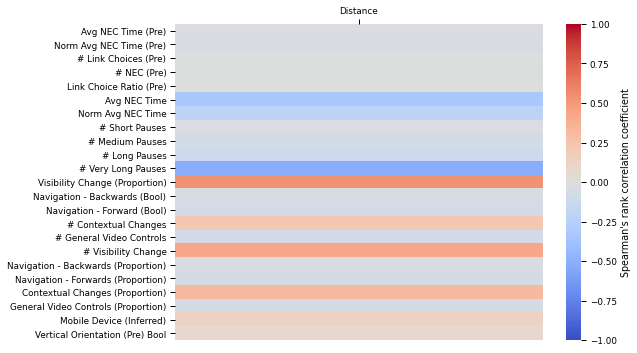

In [293]:
fig, ax = plt.subplots(figsize = (9, 5))
p = sns.heatmap(
    data = metrics[interaction_metrics + ['distance']].corr(method = 'spearman').filter(['distance']).drop(['distance']), 
    cmap = sns.color_palette('coolwarm', as_cmap = True),
    cbar_kws = {'label': "Spearman's rank correlation coefficient"},
    vmin = -1.00, vmax = 1.00,
    ax = ax
)
p.xaxis.set_ticks_position('top')
p.set(xticklabels = ['Distance'])
plt.tight_layout()
plt.show()
# plt.savefig('plots/cars-metrics-distance-correlations.png')

**Correlation Analysis between Interaction Metrics**

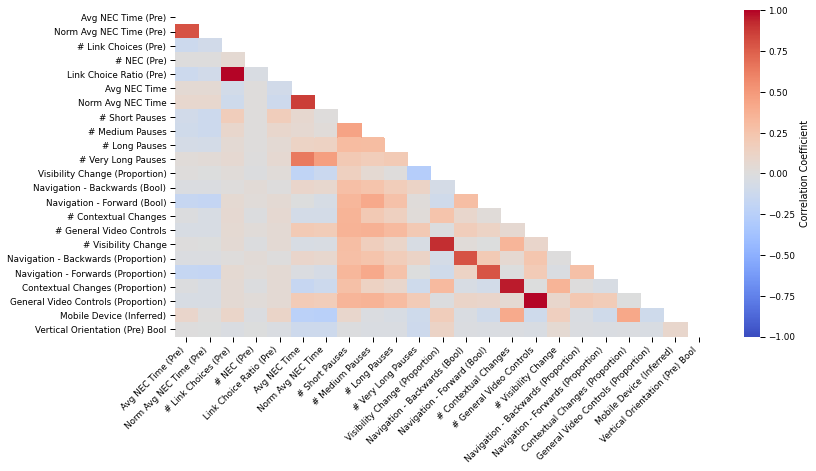

In [294]:
from lib.helpers import correlation_between_metrics

corr_results = pd.DataFrame.from_dict(correlation_between_metrics(metrics, interaction_metrics))

fig, ax = plt.subplots(figsize = (12, 6))
p = sns.heatmap(
    corr_results, xticklabels = True, yticklabels = True, ax = ax, 
    vmin = -1.00, vmax = 1.00, cmap = sns.color_palette('coolwarm', as_cmap = True), 
    cbar_kws = {'label': "Correlation Coefficient"}, 
    mask = np.triu(np.ones_like(corr_results, dtype = np.bool))
)
p.set_xticklabels(p.get_xticklabels(), rotation = 45, ha = 'right')
plt.show()

**Statistical Tests for Significant Differences**

Here we iterate over each interaction metric and split by the distance (creating six arrays of values) and compute the Kruskal Wallis test - used when you have one independent variable (the metric) with two or more levels and an ordinal dependent variable (the distance).

In [295]:
from lib.helpers import statistical_differences

distance_values = sorted(metrics['distance'].unique().tolist())
results = statistical_differences(metrics, interaction_metrics, distance_values)
pd.DataFrame.from_dict(results, orient = 'index')

,kw_statistic,p_value,sig
Avg NEC Time (Pre),38.667567,8.315723e-07,significant at 0.001
Norm Avg NEC Time (Pre),162.544896,1.711462e-32,significant at 0.001
# Link Choices (Pre),61.061813,2.738264e-11,significant at 0.001
# NEC (Pre),12.076111,6.029225e-02,non-significant
Link Choice Ratio (Pre),63.200356,1.004698e-11,significant at 0.001
Avg NEC Time,4933.525289,0.000000e+00,significant at 0.001
Norm Avg NEC Time,2411.947116,0.000000e+00,significant at 0.001
# Short Pauses,222.586536,2.921861e-45,significant at 0.001
# Medium Pauses,289.576221,1.398805e-59,significant at 0.001
# Long Pauses,575.486680,4.514965e-121,significant at 0.001


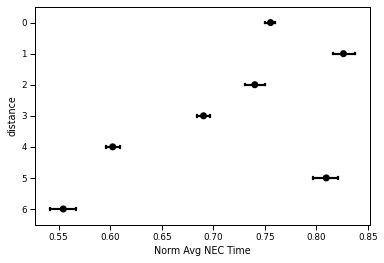

In [296]:
p = sns.pointplot(
    y = 'distance', 
    x = 'Norm Avg NEC Time', 
    data = metrics,
    join = False, 
    capsize = 0.05,
    color = 'black', 
    orient = 'h'
)

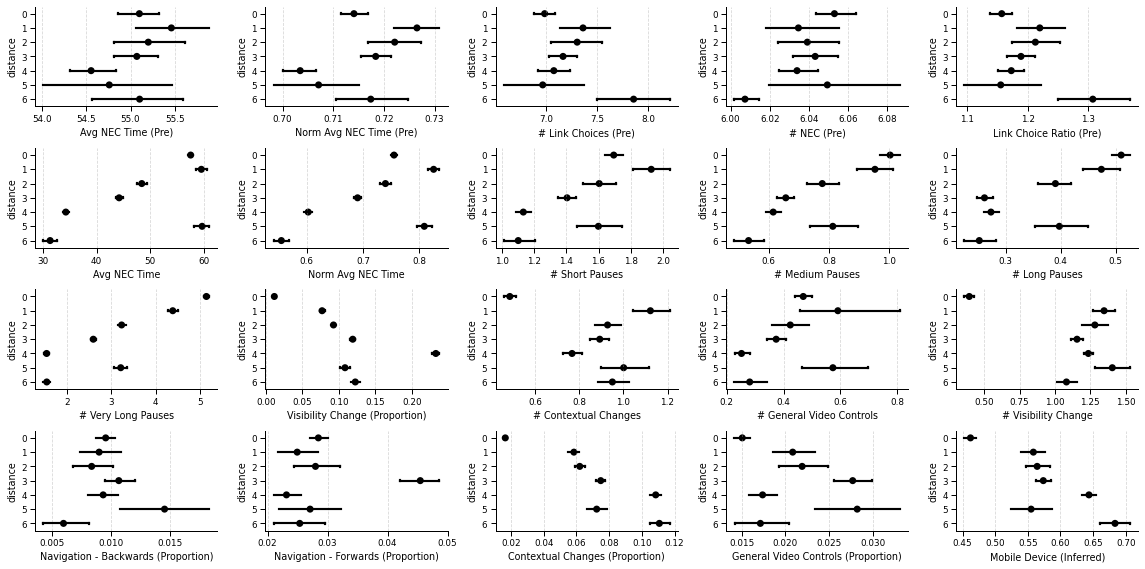

In [297]:
interaction_metrics_no_bool = [
    metric 
    for metric in interaction_metrics
    if 'Bool' not in metric
]

fig, axes = plt.subplots(nrows = 4, ncols = 5, figsize = (16, 8))

for idx, ax in enumerate(axes.ravel()):
    p = sns.pointplot(
        y = 'distance', x = interaction_metrics_no_bool[idx], 
        data = metrics, join = False, capsize = 0.05, 
        color = 'black', orient = 'h', ax = ax 
    )
    p.set(xlabel = interaction_metrics_no_bool[idx])
    p.xaxis.grid(True, alpha = 0.5, linestyle = 'dashed')

sns.despine()
plt.tight_layout()
plt.show()
# plt.savefig('plots/cars-metric-distance-effect-plot.png')

I think the above plot shows a lot of noise. It's obvious why there are significant differences between the distances but it's mostly random noise. The only interesting part is the number of visibility changes, with those finishing recording a very low number in comparison. This should make sense as it's the event that is triggered when the user moves away from the experience (changes tabs - not when they close) - users that reached the are less likely to record these.

### Modelling

In [298]:
features = list(PRETTY_NAMES.values())
target = 'distance'

In [299]:
print(f"Number of features: {len(features)}")

Number of features: 23


In [300]:
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import PoissonRegressor
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from lib.helpers import print_cross_validation_results as print_cv 
from lib.helpers import model_performance

scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_poisson_deviance']

y = metrics['distance']
X = metrics[features]

dummy_cv = cross_validate(estimator = DummyRegressor(strategy = 'mean'), X = X, y = y, scoring = scoring, cv = 10)
poisson_cv = cross_validate(
    estimator = make_pipeline(
        StandardScaler(),
        PoissonRegressor()
    ), 
    X = X, y = y, scoring = scoring, cv = 10
)

dt_cv = cross_validate( # max_depth is set to a reasonable number.
    estimator = DecisionTreeRegressor(criterion = 'poisson', random_state = 42),
    X = X, y = y, scoring = scoring, cv = 10
)
gbrt_cv = cross_validate(
    estimator = HistGradientBoostingRegressor(loss = 'poisson', max_leaf_nodes = 128, random_state = 42),
    X = X, y = y, scoring = scoring, cv = 10
)

print_cv(dummy_cv, 'Dummy', scoring)
print_cv(poisson_cv, 'Poisson Regressor', scoring)
print_cv(dt_cv, 'Decision Tree (Poisson criterion)', scoring)
print_cv(gbrt_cv, 'Hist GBT Regressor (Poisson Loss)', scoring)

Dummy
mean squared error: 3.567 (STD: 0.087)
mean absolute error: 1.695 (STD: 0.035)
mean poisson deviance: 2.204 (STD: 0.185)

Poisson Regressor
mean squared error: 2.379 (STD: 0.051)
mean absolute error: 1.297 (STD: 0.016)
mean poisson deviance: 1.610 (STD: 0.118)

Decision Tree (Poisson criterion)
mean squared error: 2.262 (STD: 0.112)
mean absolute error: 0.855 (STD: 0.028)
mean poisson deviance: 1.448 (STD: 0.088)

Hist GBT Regressor (Poisson Loss)
mean squared error: 0.957 (STD: 0.047)
mean absolute error: 0.624 (STD: 0.012)
mean poisson deviance: 0.679 (STD: 0.061)



In [301]:
from lib.helpers import paired_ttest

models = [
    make_pipeline(StandardScaler(), PoissonRegressor()),
    DecisionTreeRegressor(criterion = 'poisson', random_state = 42),
    HistGradientBoostingRegressor(loss = 'poisson', max_leaf_nodes = 128, random_state = 42)
]
dummy = DummyRegressor(strategy = 'mean')
for model in models:
    print(f"Dummy vs. {model.__class__.__name__}")
    print(paired_ttest(dummy, model, X, y), '\n')

print(f"P Reg vs. DT Reg: {paired_ttest(models[0], models[1], X, y)} \n")
print(f"P Reg vs. HGBR: {paired_ttest(models[0], models[2], X, y)}\n")
print(f"DT Reg vs. HGBR: {paired_ttest(models[1], models[2], X, y)}")

Dummy vs. Pipeline
(-71.05830827512143, 1.0454624447654174e-08, 'significant at 0.001', 'dof = 33684') 

Dummy vs. DecisionTreeRegressor
(-20.50104491847303, 5.109941441007775e-06, 'significant at 0.001', 'dof = 33684') 

Dummy vs. HistGradientBoostingRegressor
(-65.69571383616746, 1.5471810960392568e-08, 'significant at 0.001', 'dof = 33684') 

P Reg vs. DT Reg: (-3.7474402419003114, 0.013328846192059105, 'significant at 0.05', 'dof = 33684') 

P Reg vs. HGBR: (-41.15360012551144, 1.5977953429189067e-07, 'significant at 0.001', 'dof = 33684')

DT Reg vs. HGBR: (-23.195347650660967, 2.77133806602652e-06, 'significant at 0.001', 'dof = 33684')


In [302]:
import optuna 
import os 
from lib.model import OptunaObjective
from joblib import dump, load 

# create the train and test splits - the training set will be used for the hyperparameter search.
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42
)

if not os.path.isfile('models/cars_model.joblib'):
    objective = OptunaObjective(
        x_train, x_test, y_train, y_test, 'hist_gbr'
    )

    study = optuna.create_study(
        direction = 'minimize',
        sampler = optuna.samplers.TPESampler(),
        pruner = optuna.pruners.HyperbandPruner()
    )
    study.optimize(objective, n_trials = 150, callbacks = [objective.callback])

    model = objective.best_model

    print(f"Best Trial (Poisson Deviance): {study.best_trial.value:.3f}")
    print('Params:')
    for key, value in study.best_trial.params.items():
        print(f"    {key}: {value}")
    print('Model Performance:')
    
    dump(model, 'models/cars_model.joblib')
else:
    model = load('models/cars_model.joblib')
    print(f"Model parameters: {model.get_params()}")
    print('Model Performance:')

model_performance(y_test, model.predict(x_test))

Model parameters: {'categorical_features': None, 'early_stopping': 'auto', 'l2_regularization': 5.66038177523522e-05, 'learning_rate': 0.046779588863664574, 'loss': 'poisson', 'max_bins': 255, 'max_depth': 18, 'max_iter': 183, 'max_leaf_nodes': 106, 'min_samples_leaf': 17, 'monotonic_cst': None, 'n_iter_no_change': 10, 'random_state': 42, 'scoring': 'loss', 'tol': 5.14236941708928e-05, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Model Performance:
MSE: 0.957
MAE: 0.642
Mean Poisson Deviance: 0.676


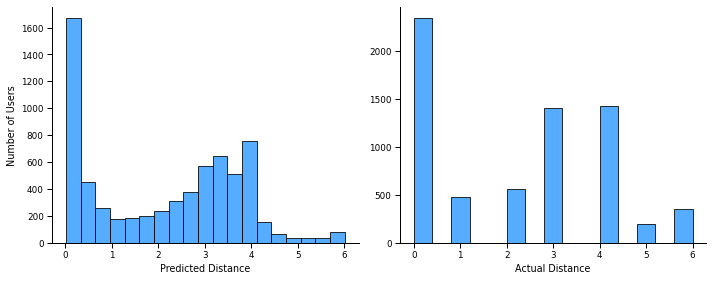

In [303]:
y_pred = model.predict(x_test)

fig, ax = plt.subplots(ncols = 2, figsize = (10, 4))
a = sns.histplot(y_pred, ax = ax[0], color = 'dodgerblue')
b = sns.histplot(y_test, ax = ax[1], color = 'dodgerblue')
a.set(xlabel = 'Predicted Distance', ylabel = 'Number of Users')
b.set(xlabel = 'Actual Distance', ylabel = '', xticks = [0, 1, 2, 3, 4, 5, 6])

sns.despine()
plt.tight_layout()
plt.show()
# plt.savefig('plots/cars_predicted_distance.png', dpi = 2400)

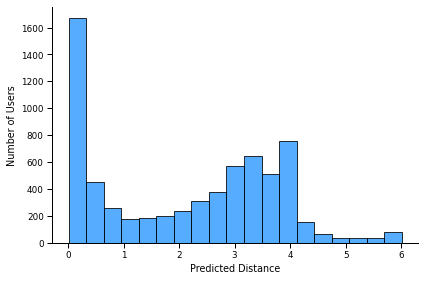

In [304]:
x = sns.histplot(y_pred, color = 'dodgerblue')
x.set(xlabel = 'Predicted Distance', ylabel = 'Number of Users')
sns.despine()
plt.tight_layout()
plt.show()
# plt.savefig('plots/cars_predicted_distance.png')

Are the two distributions the same?

We can assess this with a two-sided Kolmogorov-Smirnov test.

In [305]:
from scipy.stats import ks_2samp

ks_2samp(y_pred, y_test, alternative = 'two-sided')

KstestResult(statistic=0.34792934540596704, pvalue=0.0)

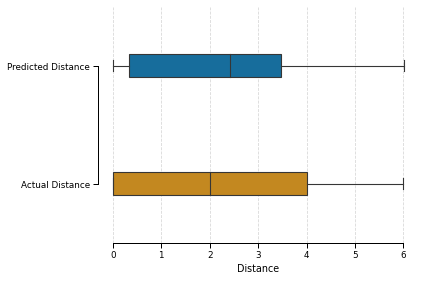

In [306]:
p = sns.boxplot(
    data = [y_pred, y_test], width = 0.2, linewidth = 1.1, notch = False, showfliers = False,
    palette = sns.color_palette('colorblind'), orient = 'h'
)
p.set(yticklabels = ['Predicted Distance', 'Actual Distance'], xlabel = 'Distance')
p.xaxis.grid(True, alpha = 0.5, linestyle = 'dashed')
p.set_axisbelow(True)
sns.despine(trim = True)
plt.tight_layout()
plt.show()

**Permutation Importance**

In [307]:
permutation_results = permutation_importance(
    estimator = model, X = x_test, y = y_test, scoring = 'neg_mean_poisson_deviance', n_repeats = 10, random_state = 42
)

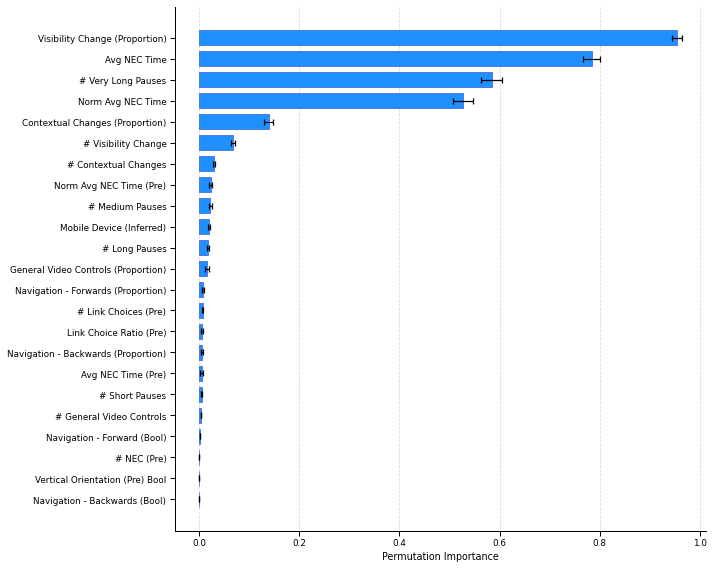

In [308]:
sorted_idx = permutation_results.importances_mean.argsort()
columns_sorted = x_test.columns[sorted_idx]
columns_std = permutation_results.importances_std[sorted_idx]
columns_m = permutation_results.importances_mean[sorted_idx]

fig, ax = plt.subplots(figsize = (10, 8))
error_kw = dict(lw = 1.25, capsize = 3, capthick = 1.25)
ax.barh(
    columns_sorted, columns_m, xerr = columns_std, align = 'center',
    error_kw = error_kw, height = 0.7, color = 'dodgerblue', edgecolor = 'royalblue'
)
ax.xaxis.grid(True, alpha = 0.5, linestyle = 'dashed')
ax.set_axisbelow(True)
ax.set_xlabel('Permutation Importance')
sns.despine()
plt.tight_layout()
plt.show()
# plt.savefig('plots/cars_permutation_importance.png')

**Accumulated Local Effects**

The relative impact on the prediction for given feature values.

In [309]:
from alibi.explainers import ALE, plot_ale

model_ale = ALE(model.predict, feature_names = features, target_names = ['distance'])
model_explain = model_ale.explain(x_test.values)
model_explain.feature_names

array(['Avg NEC Time (Pre)', 'Norm Avg NEC Time (Pre)',
       '# Link Choices (Pre)', '# NEC (Pre)', 'Link Choice Ratio (Pre)',
       'Avg NEC Time', 'Norm Avg NEC Time', '# Short Pauses',
       '# Medium Pauses', '# Long Pauses', '# Very Long Pauses',
       'Vertical Orientation (Pre) Bool', 'Navigation - Backwards (Bool)',
       'Navigation - Forward (Bool)', '# Contextual Changes',
       '# General Video Controls', 'Navigation - Backwards (Proportion)',
       'Navigation - Forwards (Proportion)',
       'Contextual Changes (Proportion)',
       'General Video Controls (Proportion)', 'Mobile Device (Inferred)',
       'Visibility Change (Proportion)', '# Visibility Change'],
      dtype='<U35')

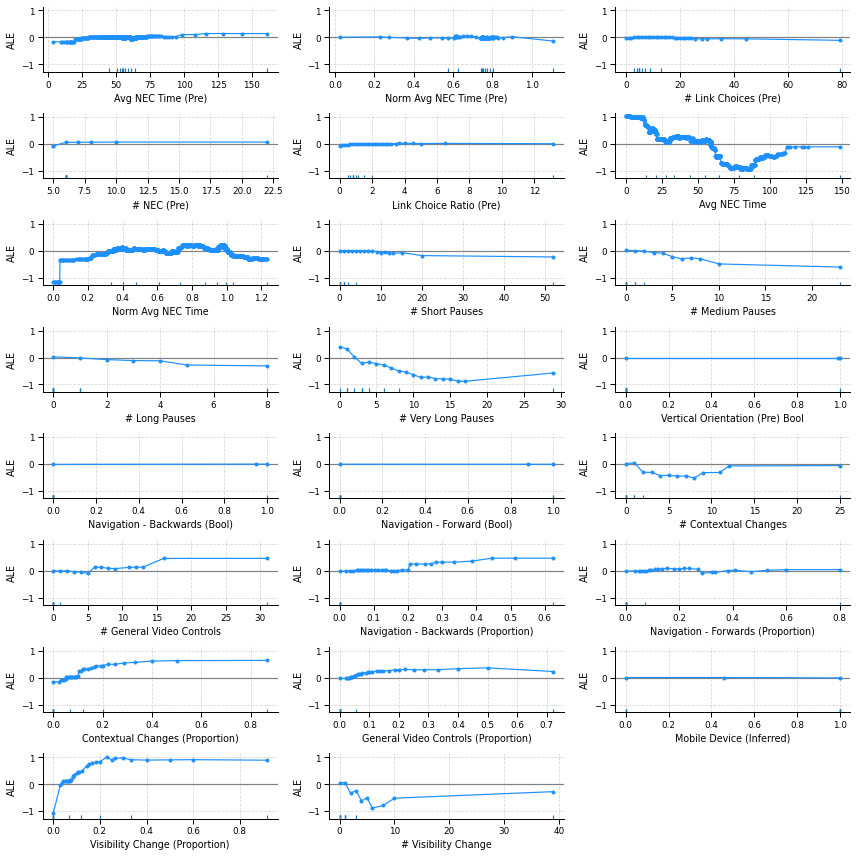

In [310]:
axes = plot_ale(
    model_explain,
    fig_kw = {'figwidth': 12, 'figheight': 12},
    line_kw = {'color': 'dodgerblue'}
)

for ax in axes.ravel()[:-1]:
    ax.xaxis.grid(True, alpha = 0.5, linestyle = 'dashed')
    ax.yaxis.grid(True, alpha = 0.5, linestyle = 'dashed')
    ax.legend_ = None
    
sns.despine()
plt.tight_layout()
plt.show()
# plt.savefig('plots/cars_ale_all_features.png')

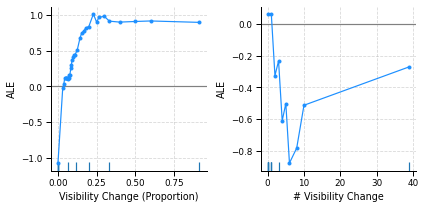

In [311]:
axes = plot_ale(
    model_explain, features = ['Visibility Change (Proportion)', '# Visibility Change'],
    fig_kw = {'figwidth': 6, 'figheight': 3},
    line_kw = {'color': 'dodgerblue'},
    sharey = None 
)

for ax in axes.ravel():
    ax.xaxis.grid(True, alpha = 0.5, linestyle = 'dashed')
    ax.yaxis.grid(True, alpha = 0.5, linestyle = 'dashed')
    ax.legend_ = None 
    
sns.despine()
plt.tight_layout()
plt.show()
# plt.savefig('plots/cars_ale_visibility_change.png')

Interesting difference here between Malawi and Cars - eventially, the # of visibility changes has no impact on the model. The broader trend is the same - a zero proportion of these events negative impacts the model and any increase in their proportion positively impacts the model. Could you monitor the proportion of these events?

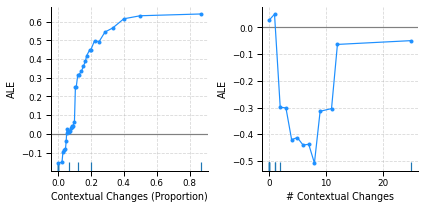

In [312]:
axes = plot_ale(
    model_explain, features = ['Contextual Changes (Proportion)', '# Contextual Changes'],
    fig_kw = {'figwidth': 6, 'figheight': 3},
    line_kw = {'color': 'dodgerblue'},
    sharey = None
)

for ax in axes.ravel():
    ax.xaxis.grid(True, alpha = 0.5, linestyle = 'dashed')
    ax.yaxis.grid(True, alpha = 0.5, linestyle = 'dashed')
    ax.legend_ = None 

sns.despine()
plt.tight_layout()
plt.show()
# plt.savefig('plots/cars_ale_contextual_changes.png')

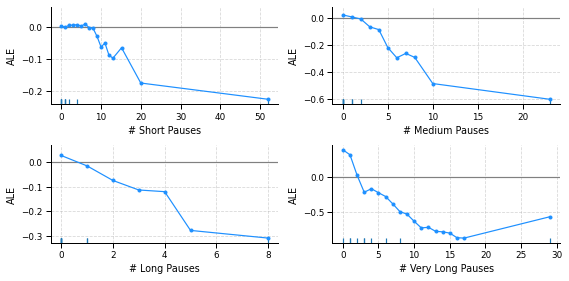

In [313]:
axes = plot_ale(
    model_explain, 
    features = ['# Short Pauses', '# Medium Pauses', '# Long Pauses', '# Very Long Pauses'], 
    fig_kw = {'figwidth': 8, 'figheight': 4},
    line_kw = {'color': 'dodgerblue'},
    sharey = None,
    n_cols = 2
)

for ax in axes.ravel()[0:4]:
    ax.xaxis.grid(True, alpha = 0.5, linestyle = 'dashed')
    ax.yaxis.grid(True, alpha = 0.5, linestyle = 'dashed')
    ax.legend_ = None

sns.despine()
plt.tight_layout()
plt.show()
# plt.savefig('plots/cars_ale_pauses.png')

An increase in the paues (all types) has a negative effect on the average prediction - pushes the prediction towards smaller values. There is an upward trend at the end of very long pauses - which isn't present in the Malawi graph.

The same trend for the general video controls is observed here as with the Malawi experience, however, the overall effect (the ALE value) is significantly lower here than it is in Malawi. VLP, MP, and LP have a stronger effect here in comparison to Malawi.

What could these mean?

- An increase in pauses of all types between interactions is suggestive of non-abandonment, or least it negatively impacts the model. 
- A higher proportion of general video controls (i.e., these events make up an increasing majority of the users total events) is suggestive of abandonment. 

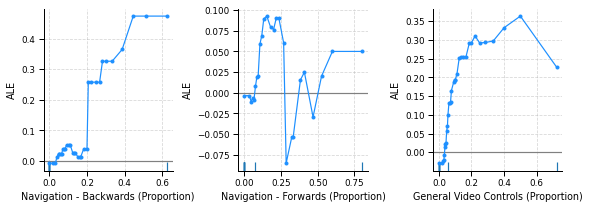

In [314]:
axes = plot_ale(
    model_explain, 
    features = ['Navigation - Backwards (Proportion)', 'Navigation - Forwards (Proportion)', 'General Video Controls (Proportion)'], 
    fig_kw = {'figwidth': 8, 'figheight': 3}, 
    line_kw = {'color': 'dodgerblue'},
    sharey = None,
    n_cols = 3
)

for ax in axes.ravel():
    ax.xaxis.grid(True, alpha = 0.5, linestyle = 'dashed')
    ax.yaxis.grid(True, alpha = 0.5, linestyle = 'dashed')
    ax.legend_ = None
    

sns.despine()
plt.tight_layout()
plt.show()
# plt.savefig('plots/cars-ale-other-metrics.png')

A large proportion of backwards navigation events (seek backwards and back button) has a positive effect on the prediction - a larger proportion trends towards abandonment. The effect is the same in the Malawi experience (but stronger).

The effect that forward navigation has on the model is up and down - but it's not overly strong (ALE values). Which is different to the Malawi - forward navigation (the proportion of them) have a strong positive effect on the model.

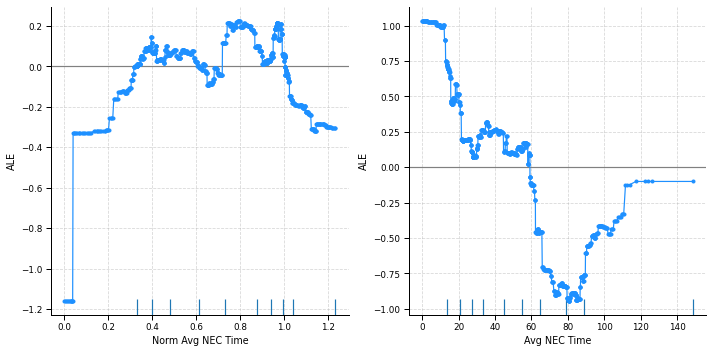

In [315]:
axes = plot_ale(
    model_explain, 
    features = ['Norm Avg NEC Time', 'Avg NEC Time'],
    fig_kw = {'figwidth': 10, 'figheight': 5},
    line_kw = {'color': 'dodgerblue'},
    sharey = None
)

for ax in axes.ravel():
    ax.xaxis.grid(True, alpha = 0.5, linestyle = 'dashed')
    ax.yaxis.grid(True, alpha = 0.5, linestyle = 'dashed')
    ax.legend_ = None
    
sns.despine()
plt.tight_layout()
plt.show()

Over 100% of a NEC watch (on average) pushes towards non-abandonment - not really sure what these plots can tell us.

In [316]:
import shap 

explainer = shap.Explainer(model)
explainer.expected_value = explainer.expected_value[0]
shap_values = explainer(x_test)

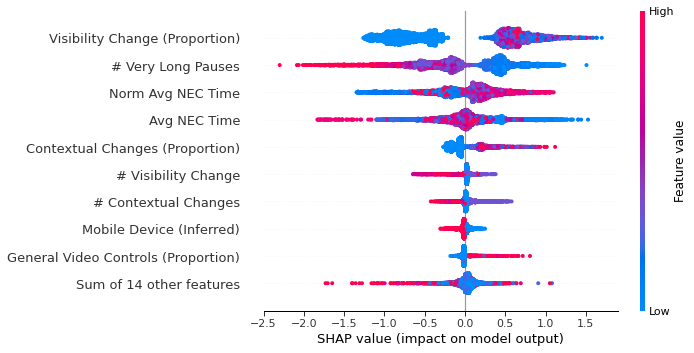

In [317]:
shap.plots.beeswarm(shap_values, show = False, plot_size = (10, 5))

plt.tight_layout()
plt.show()
# plt.savefig('plots/cars-shap-beeswarm.png')

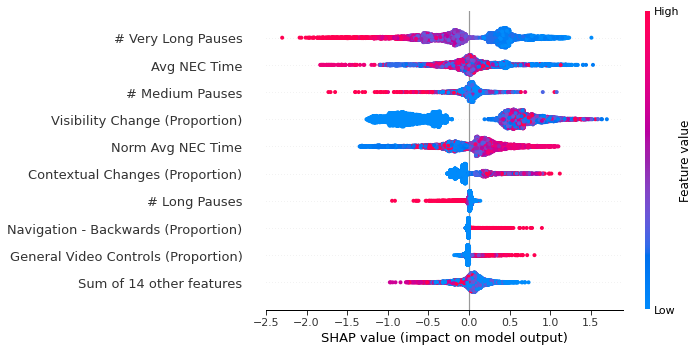

In [318]:
# high impacts for individual features we can instead sort by the max absolute value
shap.plots.beeswarm(shap_values, order = shap_values.abs.max(0))

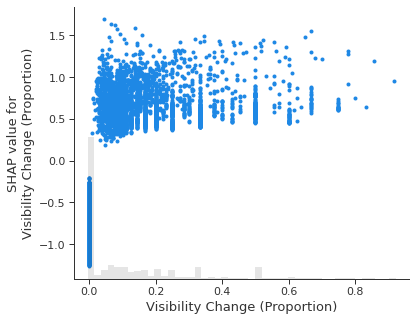

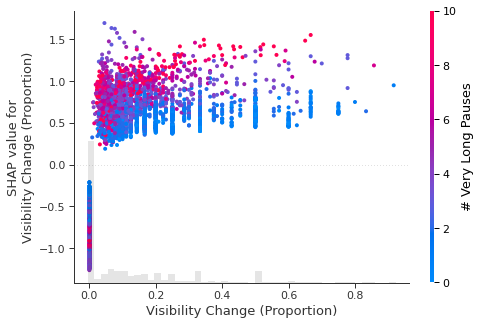

In [319]:
shap.plots.scatter(shap_values[:, 'Visibility Change (Proportion)'])
shap.plots.scatter(shap_values[:, 'Visibility Change (Proportion)'], color = shap_values)

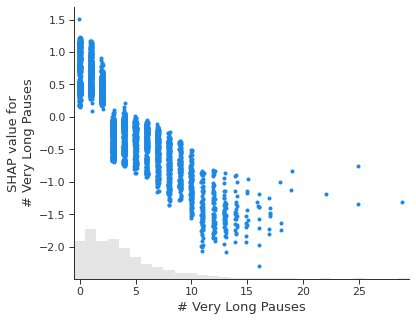

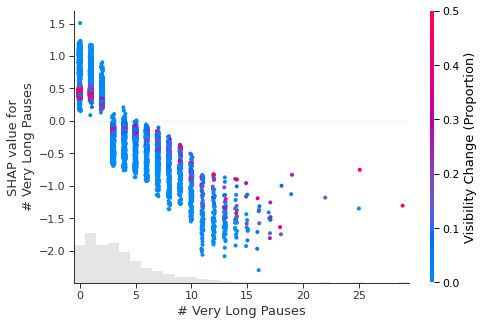

In [320]:
shap.plots.scatter(shap_values[:, '# Very Long Pauses'])
shap.plots.scatter(shap_values[:, '# Very Long Pauses'], color = shap_values)

**Relationship to Engagement**

In [321]:
from lib.helpers import process_ues_user_metrics as process_ues

ues_users = process_ues(ues_users, group_context = 'alternative_groupings')
ues_users['ues_group'] = np.where(ues_users['UES-Score'] <= ues_users['UES-Score'].median(), 'Low', 'High')

In [322]:
from lib.helpers import model_performance

ues_users['distance_predicted'] = model.predict(ues_users[features])
model_performance(ues_users['distance'], ues_users['distance_predicted'])

MSE: 0.275
MAE: 0.323
Mean Poisson Deviance: 0.645


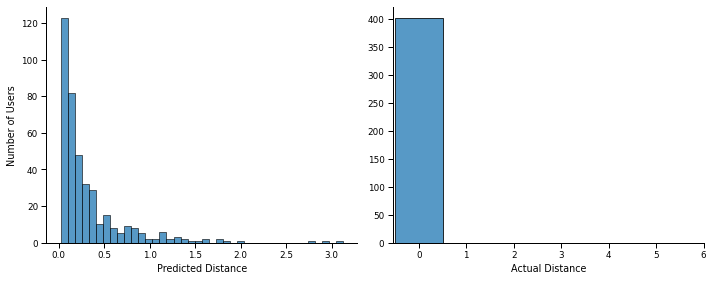

In [323]:
fig, ax = plt.subplots(ncols = 2, figsize = (10, 4))

a = sns.histplot(ues_users['distance_predicted'], ax = ax[0])
b = sns.histplot(ues_users['distance'], ax = ax[1])
a.set(xlabel = 'Predicted Distance', ylabel = 'Number of Users')
b.set(xlabel = 'Actual Distance', ylabel = '', xticks = [0, 1, 2, 3, 4, 5, 6])

sns.despine()
plt.tight_layout()
plt.show()

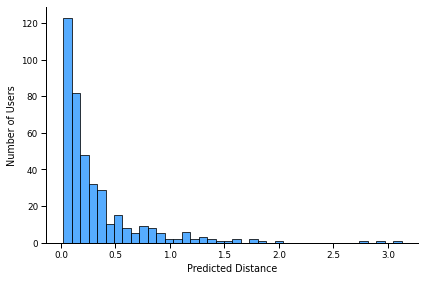

In [324]:
p = sns.histplot(ues_users['distance_predicted'], color = 'dodgerblue')
p.set(xlabel = 'Predicted Distance', ylabel = 'Number of Users')
sns.despine()
plt.tight_layout()
plt.show()
# plt.savefig('plots/cars-ues-predicted-distance-distribution.png')

In [325]:
ues_users.groupby('ues_group')['distance_predicted'].describe()

,count,mean,std,min,25%,50%,75%,max
ues_group,,,,,,,,
High,201.0,0.263366,0.345903,0.025338,0.076860,0.130222,0.274031,1.835422
Low,201.0,0.381748,0.465449,0.021468,0.102855,0.221425,0.438482,3.125217


In [326]:
from pingouin import normality, mwu

normality(data = ues_users[ues_users['ues_group'] == 'Low']['distance_predicted'], method = 'shapiro', alpha = 0.05)

,W,pval,normal
distance_predicted,0.666257,1.092724e-19,False


In [327]:
normality(data = ues_users[ues_users['ues_group'] == 'High']['distance_predicted'], method = 'shapiro', alpha = 0.05)

,W,pval,normal
distance_predicted,0.629492,1.186624e-20,False


In [328]:
mwu(
    x = ues_users[ues_users['ues_group'] == 'Low']['distance_predicted'],
    y = ues_users[ues_users['ues_group'] == 'High']['distance_predicted']
)

,U-val,tail,p-val,RBC,CLES
MWU,24887.0,two-sided,0.000057,-0.231999,0.616


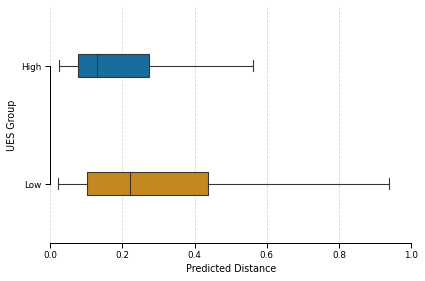

In [329]:
p = sns.boxplot(
    data = ues_users.sort_values(by = 'ues_group'), x = 'distance_predicted', y = 'ues_group',
    width = 0.2, linewidth = 1.1, notch = False, orient = 'h', showfliers = False,
    palette = sns.color_palette('colorblind')
)
p.set(ylabel = 'UES Group', xlabel = 'Predicted Distance', xlim = (0, 1))
p.xaxis.grid(True, alpha = 0.5, linestyle = 'dashed')
p.set_axisbelow(True)
sns.despine(trim = True)
plt.tight_layout()
plt.show()
# plt.savefig('plots/cars-ues-predicted-distance-boxplot.png')

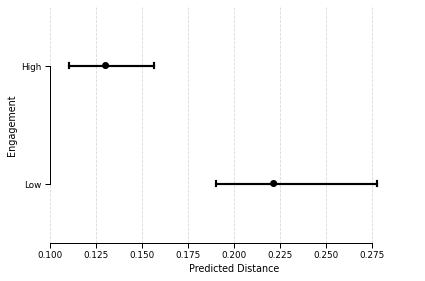

In [333]:
p = sns.pointplot(
    data = ues_users.sort_values(by = 'ues_group'), x = 'distance_predicted', y = 'ues_group', 
    join = False, capsize = 0.05, color = 'black', orient = 'h', 
    estimator = np.median 
)
p.set(ylabel = 'Engagement', xlabel = 'Predicted Distance', xlim = (0.1, 0.3))
p.xaxis.grid(True, alpha = 0.5, linestyle = 'dashed')
p.set_axisbelow(True)
sns.despine(trim = True)
plt.tight_layout()
plt.show()